# Creating a NWB 2.0 File

In this tutorial we are going to use the latest NWB 2.0 [python package](https://github.com/NeurodataWithoutBorders/pynwb) to package up some photoreceptor recordings that are currently stored in a matlab file, without annotations. 

We will aim to create two self-documenting stand alone file, which could be shared without losing any implicit information.

In this repository we have two data files WildBG6Data.mat and MutantBG6Data.mat which contain photoreceptor recording for a Wild Type drosophila and a Mutant BG6 histamine deficient fly, along with their corrisponding input data.

This tutorial is based on the following examples http://pynwb.readthedocs.io/en/latest/example.html

In [1]:
# First, we will need to import the required python packages

# Neurodata Without Borders package
import h5py
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from pynwb import NWBFile

import pynwb
from pynwb import get_manager
from pynwb.form.backends.hdf5 import HDF5IO

# Check we're using the latest version
assert pynwb.__version__ == u'0.2.0.post.dev416'

First we can load the data, using the scipy loadmat function, to extract data from matlab files, and visualise the two data sets.

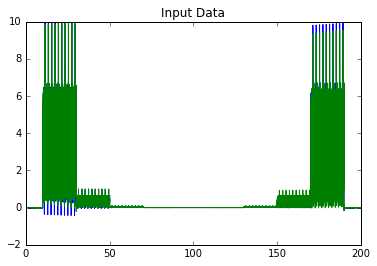

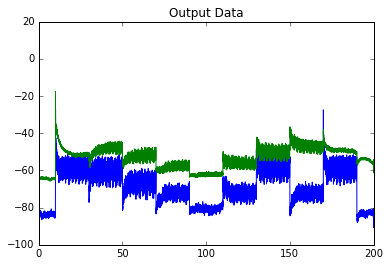

In [2]:
# Load the two data files
mutant_data = sio.loadmat('data/raw_data/MutantBG6Data.mat')
wild_data = sio.loadmat('data/raw_data/WildBG6Data.mat')


# Add the associated Input Data
freq = 1/400.0
timestamps = np.arange(0,freq*len(wild_data['recorded_input']),freq)

# Plot the input trace
plt.plot(timestamps,wild_data['recorded_input']); 
plt.plot(timestamps,mutant_data['recorded_input']); 
plt.title('Input Data')
plt.show()

# Plot the output trace
plt.plot(timestamps,wild_data['recorded_output']); 
plt.plot(timestamps,mutant_data['recorded_output']); 
plt.title('Output Data')
plt.show()

To create a NWB file, we start by defining a  NWBFile file object. This will store the basic information such as the filename, the itendifier, the start time of the experiment and a general description of the file.

In [3]:
f = NWBFile('WildType', 
            'A file storing the drosophila photoreceptor data for wild type flys.', 
            'Wild01', 
            "2011-01-01T00:00:00.604121Z",
            experimenter='Uwe',
            lab='Coca Lab',
            institution='University of Sheffield',
            experiment_description='Photoreceptor stimulation with histamine transmission.',
            session_id='Wild01')

Next, we can create Epochs for our experiments. In this file, we will define two epochs, one where the stimulus intensity is decreasing, and one where it is increasing. In practice some models are tuned to only reproduce the increasing stimulus stimulations.

In [4]:
epoch_tags = ('intensity',)

# The first epoch will cover the decreasing intensity stimulation from t=0 s to t=100 s
ep1 = f.create_epoch(source='WildType', name='epoch_01', start=0.0, stop=100.0,
                     tags=epoch_tags,
                     description="decreasing intensity stimulation")

# The first epoch will cover the decreasing intensity stimulation from t=100 s to t=200 s
ep2 = f.create_epoch(source='WildType', name='epoch_02', start=100.0, stop=200.0,
                     tags=epoch_tags,
                     description="increasing intensity stimulation")

# WIP: How to retrieve Epoch start and stop times after the fact

Next, in order to add any timeseries data, as we see above, we need to add the electrodes that the data came from. In this case I currently have very little information on the electrods to add, so we will create a dummy electrode object

In [5]:
device = f.create_device(name='trodes_rig', source="Sutter Instrument, model P-2000")

electrode_name = 'tetrode1'
source = "WildType"
description = "An abstract electrode placeholder"
location = "Photoreceptor"

electrode_group = f.create_electrode_group(electrode_name,
                                           source=source,
                                           description=description,
                                           location=location,
                                           device=device)

f.add_electrode(0,
                x=0.0, y=0.0, z=0.0,
                imp=float(-0),
                location='Retina', filtering='none',
                description='Abstract Electrode' , group=electrode_group)

electrode_table_region = f.create_electrode_table_region([0], 'the first electrode')

Now we can start to add the timeseries data we have. We will be adding two types of timeseries data, the 'Aquisition' data which represents our output data from the photoreceptors.

In [32]:
from pynwb.ecephys import ElectricalSeries

# Open out data file
wild_data = sio.loadmat('data/raw_data/WildBG6Data.mat')
ephys_data = wild_data['recorded_output']

# create the time stamps to match our output data. 
freq = 1/400.0
ephys_timestamps = np.arange(0,freq*len(wild_data['recorded_output']),freq)

# Now we can create out Electrical Series object which represent 
ephys_ts = ElectricalSeries('wild_type_01',
                            'wild_type photoreceptor',
                            ephys_data,
                            electrode_table_region,
                            timestamps=ephys_timestamps,
                            resolution=0.001,
                            comments="Includes both increasing and decreasing stimulation",
                            description="Wild Type photoreceptor output")

# We add the epochs we created earlier to this dataset
f.add_acquisition(ephys_ts, [ep1, ep2])


ValueError: 'wild_type_01' already exists in 'root'

Next we add the associated stimulus data using the add_stimulus method. We will use the same name as the aquisition data, to ensure that they can be retrieved together later

In [8]:
# Add the associated Input Data
stimulus_timestamps = np.arange(0,freq*len(wild_data['recorded_input']),freq)
stimulus_data = wild_data['recorded_input']

stimulus_ts = ElectricalSeries('wild_type_01',
                            'wild_type photoreceptor',
                            stimulus_data,
                            electrode_table_region,
                            timestamps=stimulus_timestamps,
                            resolution=0.001,
                            comments="Includes both increasing and decreasing stimulation",
                            description="Wild Type photoreceptor stimulation")
f.add_stimulus(stimulus_ts, [ep1, ep2])


Finally, we can can output the file like so:

In [33]:
filename = "data/nwb2.0/wild_photoreceptor_data.nwb"

io = HDF5IO(filename, manager=get_manager(), mode='w')
io.write(f)
io.close()

IOError: Unable to create file (unable to truncate a file which is already open)

# Inspecting the NWB files

We can now re-open the generated NWB files using the standard H5PY module and print out the contents

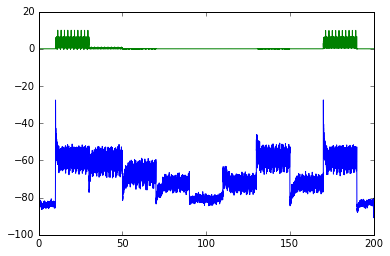

In [10]:
wild = h5py.File('data/nwb2.0/wild_photoreceptor_data.nwb')
plt.plot(wild['acquisition']['wild_type_01']['timestamps'],wild['acquisition']['wild_type_01']['data'][:])
plt.plot(wild['stimulus']['presentation']['wild_type_01']['timestamps'],wild['stimulus']['presentation']['wild_type_01']['data'][:])
plt.show()
wild.close()

In [35]:
#We can attempt to open the file using pynwb, however this can have issues
filename = "data/nwb2.0/wild_photoreceptor_data.nwb"
io = HDF5IO(filename, manager=get_manager(), mode='r')

In [36]:
fr = io.read()

Exception: Could not construct Epoch object
    incorrect type for 'tags' (got 'H5Dataset', expected 'tuple or list'): Epoch (epoch2)